In [1]:
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.font_manager as fm
from matplotlib import font_manager, rc
import seaborn as sns
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from numpy import dot 
from numpy.linalg import norm
from libpysal.weights.contiguity import Queen
import splot
from esda.moran import Moran
from splot.esda import moran_scatterplot
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
from scipy import stats
from scipy.stats import kurtosis
import os
import copy
import time

mpl.rcParams['axes.unicode_minus'] = False
warnings.simplefilter('ignore')

font_path = r'C:/Users/user/NanumFontSetup_TTF_ALL/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=font_path, size=18).get_name()
rc('font',family=font_name)

# 1. Data Load

In [2]:
data_path = '../data/Dataset' 
os.listdir(data_path)

['fixed_dataset(매출건수).csv',
 'fixed_dataset(자동차유지,10퍼센트절사평균).csv',
 'fixed_dataset(자동차제거,null유지).csv',
 'fixed_dataset(자동차제거,매출log,null유지).csv',
 'fixed_dataset(자동차제거,매출log,null유지,절사평균).csv',
 'fixed_dataset(자동차제거,매출raw,null유지).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,1126).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,1201).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,원래연면적,1201).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,원래연면적,버퍼점포밀도,1202).csv',
 'fixed_dataset.csv',
 'fixed_dataset_1105.csv',
 'fixed_dataset_1214.csv']

In [3]:
# 1. 매출 log, null 유지
data = pd.read_csv(os.path.join(data_path,'fixed_dataset_1214.csv'),encoding='euc-kr')

# 2. 자동차제거,매출log,null유지,절사평균
# data = pd.read_csv(os.path.join(data_path,'fixed_dataset(자동차제거,매출log,null유지,절사평균).csv'),encoding='euc-kr')
data.head()

,BAS_ID,BAS_AR,도로길이고려_전체통합도,도로길이고려_국부통합도_R3,기초구역평균_전체통합도,기초구역평균_국부통합도_R3,도로율,평균 도로 길이,아파트시세변화_차분평균,평균영업기간,...,서비스업종다양성,소매업종다양성,상가밀도,주중 / 주말,06 to 18 / 18 to 06,개별공시지가 변화 차분평균,(주거인구+직장인구) / 유동인구,주거인구/직장인구,10_30 / 40_60,점포밀도
0,21300,0.743330,617.130076,7987.604945,0.060037,0.907932,7.332336,119.253463,0.000,163.106482,...,1.609438,2.390980,86.099041,2.342449,2.695669,31337.73585,0.268398,0.149563,0.406896,7.046875
1,21301,0.121045,221.397046,2876.534944,0.069661,0.938454,30.948119,211.340833,305.909,156.249615,...,1.127535,1.985080,346.978396,2.315147,2.280277,344640.00000,0.254881,0.667946,0.439757,11.523810
2,21302,0.175777,341.252878,4162.583064,0.087372,1.084619,25.546905,214.144187,0.000,111.950730,...,2.029155,1.314799,876.110071,2.064957,2.339853,174949.46240,0.220317,0.899425,0.508371,143.584416
3,21303,0.270679,475.038010,6080.093135,0.084712,1.079401,15.517121,105.011320,912.500,153.728003,...,2.364045,2.064017,232.748015,2.273528,2.246297,97041.79104,0.108296,6.308614,0.441902,36.111111
4,21304,0.073319,273.241567,3575.514233,0.092931,1.107098,32.713927,134.361765,369.231,177.329451,...,2.289920,2.379112,2495.942389,2.016228,2.004099,166589.33650,0.212989,1.959390,0.479893,113.836066


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BAS_ID               161 non-null    int64  
 1   BAS_AR               161 non-null    float64
 2   도로길이고려_전체통합도         161 non-null    float64
 3   도로길이고려_국부통합도_R3      161 non-null    float64
 4   기초구역평균_전체통합도         161 non-null    float64
 5   기초구역평균_국부통합도_R3      161 non-null    float64
 6   도로율                  161 non-null    float64
 7   평균 도로 길이             161 non-null    float64
 8   아파트시세변화_차분평균         161 non-null    float64
 9   평균영업기간               158 non-null    float64
 10  평균폐업기간               151 non-null    float64
 11  평균최근접역거리             160 non-null    float64
 12  평균최근접정류장거리           160 non-null    float64
 13  건물노후도                161 non-null    float64
 14  공동주택 비율              161 non-null    float64
 15  근린생활시설 비율            161 non-null    flo

## 1.1 결측치 확인

In [5]:
drop_list = [col for col in list(data) if '변화' in col]
drop_list += ['BAS_AR','건물노후도']
data = data.drop(drop_list,axis=1)

In [6]:
data.isnull().sum()

BAS_ID                  0
도로길이고려_전체통합도            0
도로길이고려_국부통합도_R3         0
기초구역평균_전체통합도            0
기초구역평균_국부통합도_R3         0
도로율                     0
평균 도로 길이                0
평균영업기간                  3
평균폐업기간                 10
평균최근접역거리                1
평균최근접정류장거리              1
공동주택 비율                 0
근린생활시설 비율               0
단독주택 비율                 0
아파트 가구수                 0
외식업매출비율                 8
서비스업매출비율                5
소매업매출비율                 5
외식업종다양성                 1
서비스업종다양성                1
소매업종다양성                 1
상가밀도                    1
주중 / 주말                 0
06 to 18 / 18 to 06     0
(주거인구+직장인구) / 유동인구      0
주거인구/직장인구               0
10_30 / 40_60           0
점포밀도                    1
dtype: int64

### 1.1.1 운영 평균 영업 개월, 폐업 평균 영업 개월
- 운영 평균 영업 개월 : 영업, 폐업 둘 다 없을 경우 제거
- 폐업 평균 영업 개월 : 영업, ㅍ영업기간은 있지만 폐업기간이 없을 경우 제거

In [7]:
data[data['평균폐업기간'].isnull()][['BAS_ID','평균영업기간','평균폐업기간','점포밀도']]

,BAS_ID,평균영업기간,평균폐업기간,점포밀도
22,21322,201.466149,NaN,2.666667
27,21327,89.858108,NaN,12.000000
39,21339,82.104355,NaN,0.000000
72,21372,NaN,NaN,28.500000
73,21373,252.747147,NaN,26.633333
75,21375,NaN,NaN,2.000000
81,21381,183.029083,NaN,16.920000
86,21386,132.306618,NaN,10.750000
159,21459,165.177930,NaN,2.666667
160,21460,NaN,NaN,NaN


In [8]:
# 제거할 row 정의 및 제거

drop_index = list(data[data['평균영업기간'].isnull()].index)

clean_data = data.drop(drop_index,axis=0).reset_index(drop=True)

In [9]:
clean_data.isnull().sum()

BAS_ID                 0
도로길이고려_전체통합도           0
도로길이고려_국부통합도_R3        0
기초구역평균_전체통합도           0
기초구역평균_국부통합도_R3        0
도로율                    0
평균 도로 길이               0
평균영업기간                 0
평균폐업기간                 7
평균최근접역거리               0
평균최근접정류장거리             0
공동주택 비율                0
근린생활시설 비율              0
단독주택 비율                0
아파트 가구수                0
외식업매출비율                5
서비스업매출비율               3
소매업매출비율                3
외식업종다양성                0
서비스업종다양성               0
소매업종다양성                0
상가밀도                   0
주중 / 주말                0
06 to 18 / 18 to 06    0
(주거인구+직장인구) / 유동인구     0
주거인구/직장인구              0
10_30 / 40_60          0
점포밀도                   0
dtype: int64

In [10]:
# 평균 폐업 기간은 어차피 쓰지 않으므로 0으로 치환해도 상관 X
# 매출 비율 데이터가 없는 경우는 매출 데이터가 없는 경우이므로 0으로 치환
clean_data.fillna(0,inplace=True)

In [11]:
clean_data.isnull().sum()

BAS_ID                 0
도로길이고려_전체통합도           0
도로길이고려_국부통합도_R3        0
기초구역평균_전체통합도           0
기초구역평균_국부통합도_R3        0
도로율                    0
평균 도로 길이               0
평균영업기간                 0
평균폐업기간                 0
평균최근접역거리               0
평균최근접정류장거리             0
공동주택 비율                0
근린생활시설 비율              0
단독주택 비율                0
아파트 가구수                0
외식업매출비율                0
서비스업매출비율               0
소매업매출비율                0
외식업종다양성                0
서비스업종다양성               0
소매업종다양성                0
상가밀도                   0
주중 / 주말                0
06 to 18 / 18 to 06    0
(주거인구+직장인구) / 유동인구     0
주거인구/직장인구              0
10_30 / 40_60          0
점포밀도                   0
dtype: int64

## 1.2 geometry 정보 로딩

In [12]:
basis_area= gpd.read_file('../data/전처리 파일/부평구_기초구역_5181/부평구_기초구역_4326.shp')
basis_area.head()

,BAS_AR,BAS_ID,BAS_MGT_SN,CTP_KOR_NM,MVMN_DE,MVMN_RESN,NTFC_DE,OPERT_DE,SIG_CD,SIG_KOR_NM,center_x,center_y,geometry
0,2.648838,21459,2823700025,인천광역시,None,None,20121221,None,28237,부평구,126.742914,37.474121,"POLYGON ((126.73590 37.48296, 126.73597 37.482..."
1,0.156212,21384,2823700061,인천광역시,None,None,20121221,None,28237,부평구,126.708049,37.489905,"POLYGON ((126.70977 37.49105, 126.70987 37.491..."
2,0.076024,21403,2823700058,인천광역시,None,None,20121221,None,28237,부평구,126.732706,37.489535,"POLYGON ((126.73383 37.48969, 126.73431 37.489..."
3,0.527205,21447,2823700035,인천광역시,None,None,20121221,None,28237,부평구,126.694834,37.482046,"POLYGON ((126.69892 37.48537, 126.69960 37.485..."
4,0.073898,21421,2823700036,인천광역시,None,None,20121221,None,28237,부평구,126.737058,37.484080,"POLYGON ((126.73785 37.48219, 126.73772 37.482..."


In [13]:
use_basis_area = basis_area[['BAS_ID','geometry']]
use_basis_area.head()

,BAS_ID,geometry
0,21459,"POLYGON ((126.73590 37.48296, 126.73597 37.482..."
1,21384,"POLYGON ((126.70977 37.49105, 126.70987 37.491..."
2,21403,"POLYGON ((126.73383 37.48969, 126.73431 37.489..."
3,21447,"POLYGON ((126.69892 37.48537, 126.69960 37.485..."
4,21421,"POLYGON ((126.73785 37.48219, 126.73772 37.482..."


In [14]:
clean_data['BAS_ID'] = clean_data['BAS_ID'].astype(str) # string 티입으로 변환
clean_data = clean_data.merge(use_basis_area,how='left',right_on='BAS_ID',left_on='BAS_ID').sort_values(by='BAS_ID')
clean_data.head()

,BAS_ID,도로길이고려_전체통합도,도로길이고려_국부통합도_R3,기초구역평균_전체통합도,기초구역평균_국부통합도_R3,도로율,평균 도로 길이,평균영업기간,평균폐업기간,평균최근접역거리,...,서비스업종다양성,소매업종다양성,상가밀도,주중 / 주말,06 to 18 / 18 to 06,(주거인구+직장인구) / 유동인구,주거인구/직장인구,10_30 / 40_60,점포밀도,geometry
0,21300,617.130076,7987.604945,0.060037,0.907932,7.332336,119.253463,163.106482,199.056791,1.172716,...,1.609438,2.390980,86.099041,2.342449,2.695669,0.268398,0.149563,0.406896,7.046875,"POLYGON ((126.69032 37.52345, 126.69084 37.523..."
1,21301,221.397046,2876.534944,0.069661,0.938454,30.948119,211.340833,156.249615,52.896363,1.696683,...,1.127535,1.985080,346.978396,2.315147,2.280277,0.254881,0.667946,0.439757,11.523810,"POLYGON ((126.69791 37.52246, 126.69791 37.522..."
2,21302,341.252878,4162.583064,0.087372,1.084619,25.546905,214.144187,111.950730,93.787005,1.697811,...,2.029155,1.314799,876.110071,2.064957,2.339853,0.220317,0.899425,0.508371,143.584416,"POLYGON ((126.70466 37.52105, 126.70466 37.521..."
3,21303,475.038010,6080.093135,0.084712,1.079401,15.517121,105.011320,153.728003,161.293272,1.802432,...,2.364045,2.064017,232.748015,2.273528,2.246297,0.108296,6.308614,0.441902,36.111111,"POLYGON ((126.70215 37.51767, 126.70204 37.517..."
4,21304,273.241567,3575.514233,0.092931,1.107098,32.713927,134.361765,177.329451,100.922903,1.604301,...,2.289920,2.379112,2495.942389,2.016228,2.004099,0.212989,1.959390,0.479893,113.836066,"POLYGON ((126.70466 37.52105, 126.70466 37.521..."


In [15]:
center = gpd.GeoDataFrame(clean_data).centroid

clean_data['x'] = center.x
clean_data['y'] = center.y

clean_data.iloc[:,-3:].head()

,geometry,x,y
0,"POLYGON ((126.69032 37.52345, 126.69084 37.523...",126.689135,37.518708
1,"POLYGON ((126.69791 37.52246, 126.69791 37.522...",126.695459,37.522417
2,"POLYGON ((126.70466 37.52105, 126.70466 37.521...",126.701342,37.522339
3,"POLYGON ((126.70215 37.51767, 126.70204 37.517...",126.698730,37.518981
4,"POLYGON ((126.70466 37.52105, 126.70466 37.521...",126.703419,37.519319


## 1.3 기초통계량

In [16]:
basis_stat = clean_data.iloc[:,1:-3].describe().transpose().apply(lambda x : round(x,4))
basis_stat

,count,mean,std,min,25%,50%,75%,max
도로길이고려_전체통합도,158.0,346.0538,170.2782,48.4633,223.2449,304.9494,441.1728,938.4161
도로길이고려_국부통합도_R3,158.0,4082.2266,2019.4656,501.5583,2664.5452,3754.0121,5150.0262,11731.5519
기초구역평균_전체통합도,158.0,0.0947,0.0179,0.0532,0.0848,0.0953,0.1058,0.1795
기초구역평균_국부통합도_R3,158.0,1.0892,0.0848,0.8628,1.0489,1.0904,1.1414,1.3324
도로율,158.0,28.0544,12.9631,0.0140,19.4400,27.6773,36.1936,62.5353
평균 도로 길이,158.0,167.4987,82.6776,49.0535,113.5915,144.3352,202.4410,535.7467
평균영업기간,158.0,133.1065,31.7456,41.1814,117.7432,132.4636,151.0212,252.7471
평균폐업기간,158.0,102.8609,45.6891,0.0000,78.0784,100.6919,126.1925,244.4929
평균최근접역거리,158.0,0.7244,0.4906,0.1039,0.3503,0.5578,0.9591,1.9089
평균최근접정류장거리,158.0,0.0862,0.0435,0.0335,0.0612,0.0759,0.0968,0.3319


In [17]:
basis_stat.drop(['25%','50%','75%'],axis=1).to_csv('../data/전처리 파일/기초통계량.csv',encoding='euc-kr')

## 1.4 데이터 분포 확인

In [18]:
ind_var = clean_data.drop(['BAS_ID','geometry','x','y','평균영업기간','평균폐업기간'],axis=1)

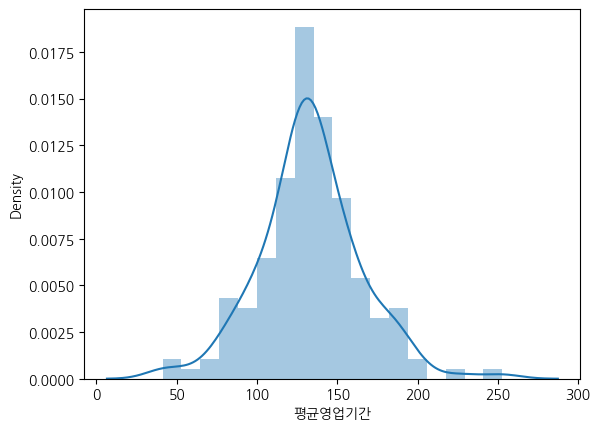

In [19]:
sns.distplot(clean_data['평균영업기간'])
plt.show()

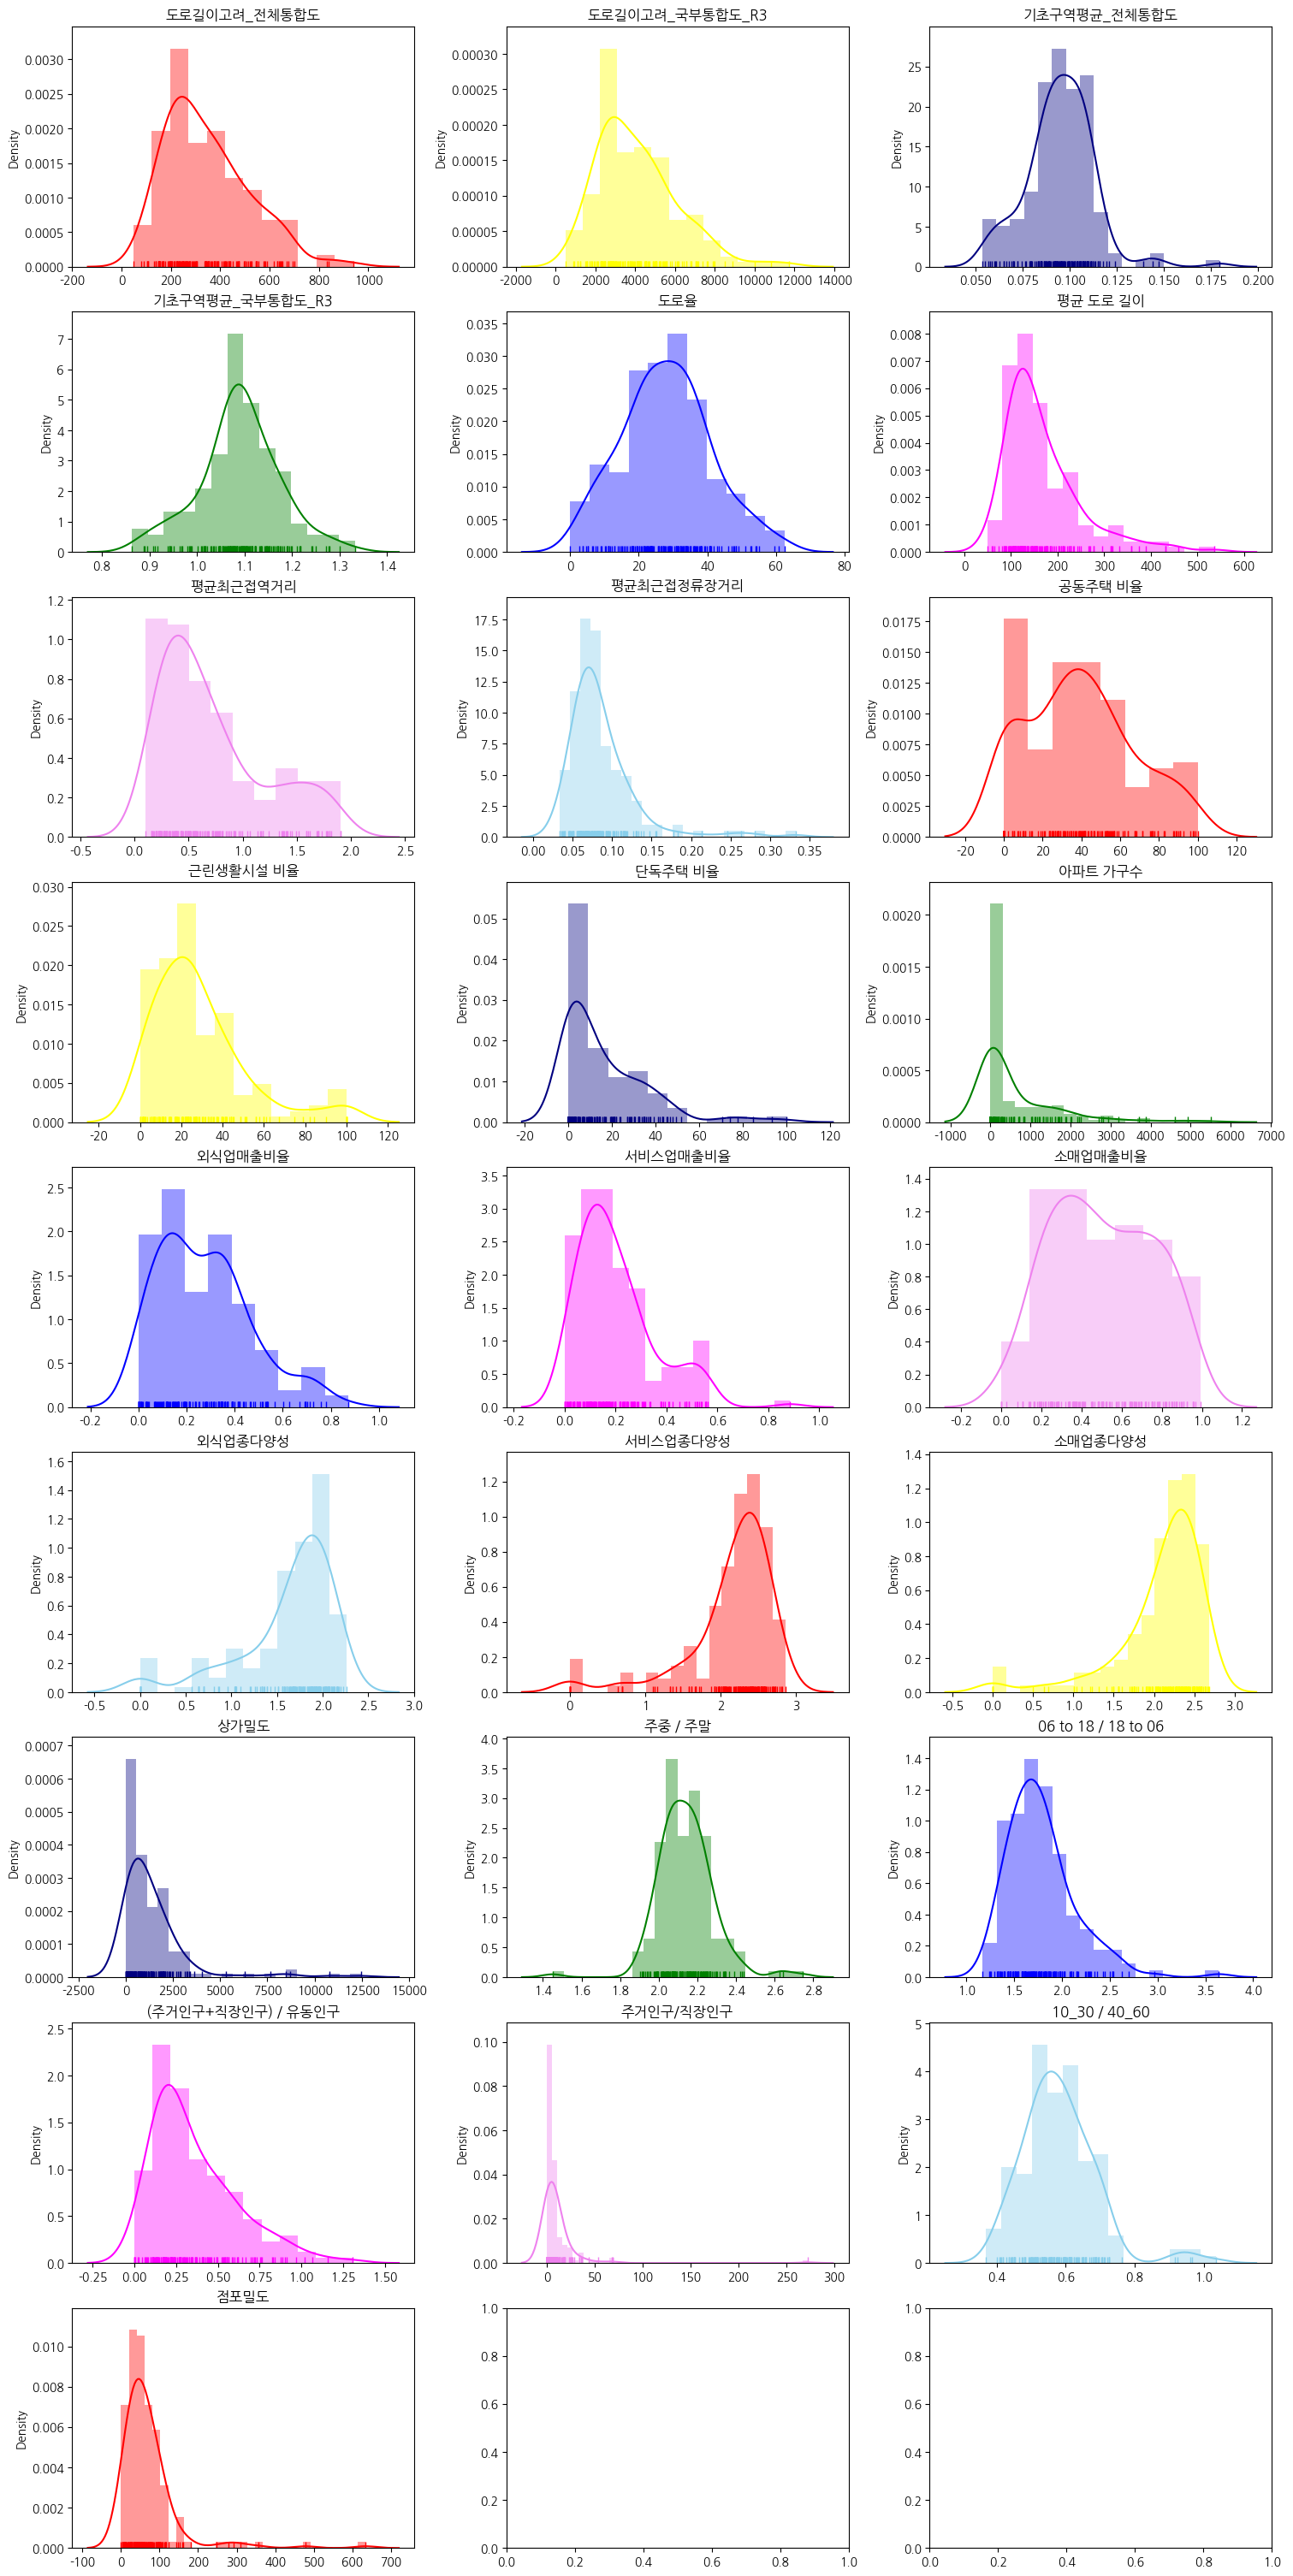

In [20]:
col_list = list(ind_var)
nrows = int(len(col_list)/3)+1
ncols = 3

fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(15,30),constrained_layout=True)
color = ['red','yellow','navy','green','blue','magenta','violet','skyblue']

for i in range(nrows):
    for j in range(ncols):
        if (ncols*i+j) == len(col_list):
            break
        
        sns.distplot(ax=axes[i,j], x=ind_var[col_list[(ncols*i+j)]], kde=True,color=color[(ncols*i+j) % len(color)],rug=True)
        axes[i,j].set_title(col_list[ncols*i+j])

plt.savefig('../data/결과 이미지/기초통계량 분포.jpg')
plt.show()

## 1.5 다중공선성 확인 및 제거

In [21]:
def check_vif(dX):
    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(dX.values,i) for i in range(dX.values.shape[1])] 
    vif['features'] = dX.columns
    vif = vif.sort_values("VIF Factor").reset_index(drop=True)
    
    return vif

result = check_vif(ind_var)
result.iloc[-5:,]

,VIF Factor,features
20,167.194070,도로길이고려_국부통합도_R3
21,176.870832,도로길이고려_전체통합도
22,179.053716,기초구역평균_전체통합도
23,334.075718,주중 / 주말
24,424.057135,기초구역평균_국부통합도_R3


In [22]:
def RFE(df):
    flag = True
    next_col = list(df.columns)
    
    while flag:
        local = df.loc[:,next_col]
        result = check_vif(local)

        if len(result[result['VIF Factor'] > 10]) == 0:
            return result # 유일한 탈출 조건
        
#         display(result[-7:])
        next_col = result.iloc[:-1,1].values.tolist()
        
vif_result = RFE(ind_var)
optimal_feature = vif_result['features'].values.tolist()
optimal_feature

['주거인구/직장인구',
 '아파트 가구수',
 '단독주택 비율',
 '서비스업매출비율',
 '외식업매출비율',
 '근린생활시설 비율',
 '평균최근접역거리',
 '(주거인구+직장인구) / 유동인구',
 '공동주택 비율',
 '평균 도로 길이',
 '도로길이고려_전체통합도',
 '평균최근접정류장거리',
 '점포밀도',
 '도로율',
 '상가밀도']

# 2. 공간적 상관성 및 공간적 이질성 검증

## 2.1 Moran's I 검정
- H0 : 군집이 존재하지 않는다. 즉, 모든 구역이 Randomness를 가진다.(AutoCorrelation이 없다.)
- 유의 수준 : 0.05
- 검정통계량 : Morans'I

In [23]:
gdf = gpd.GeoDataFrame(clean_data.geometry)
y = clean_data['평균영업기간'].values

w = Queen.from_dataframe(gdf)
moran = Moran(y, w)
moran.I

0.21401617344368642

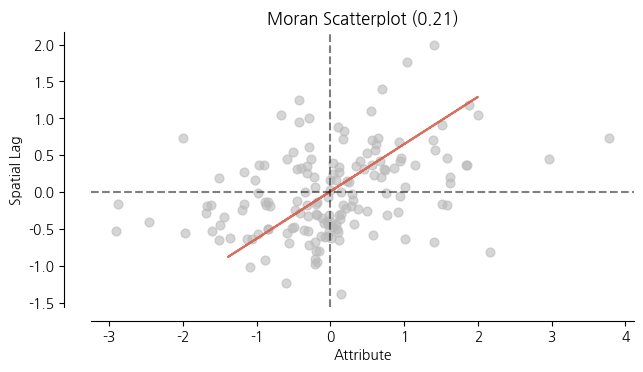

In [24]:
spatial_path = '../data/결과 이미지/공간적 상관성 및 이질성'

fig, ax = moran_scatterplot(moran, aspect_equal=True)

plt.show()

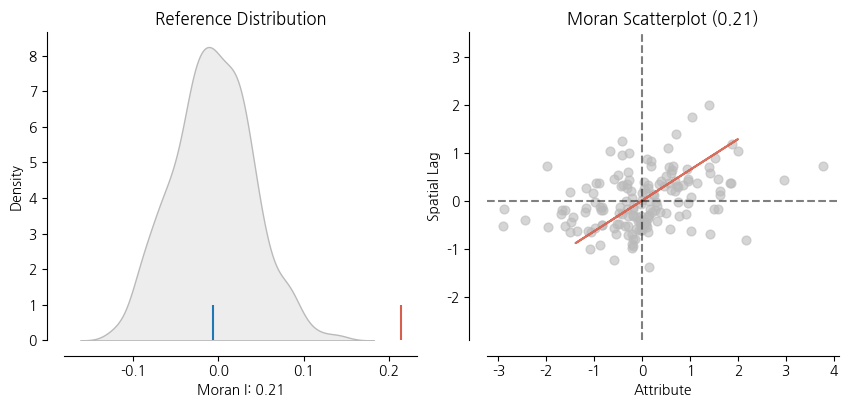

In [25]:
from splot.esda import plot_moran

plot_moran(moran, zstandard=True, figsize=(10,4))
plt.savefig(os.path.join(spatial_path,'moran\'s I(평균영업기간).jpg'))
plt.show()

In [26]:
moran.p_sim

0.001

- p-value가 0.001이므로 유의수준 5%이내에서 전역적으로 보았을 때 군집이 존재하다고 이야기 할수 있다.

## 2.2 LISA 분석
- 왜 국지적 모델(GWR)을 써야하는가?
- Morans'I를 통해서 공간적 의존성은 확인할 수 있으나 공간적 이질성은 확인할 수가 없다.
- 공간적 의존성 : 공간상의 한 지점에서 측정된 현상이 다른 지점에서의 측정값과 서로 관련이 있을 때 나타난다.
- 공간적 이질성 : 각 지점이나 지역에 내재된 고유성에서 발생하게 되는 자료의 지리적 변이나 통계적 특성의 차이를 말한다.
- LISA 검정을 통해서 공간적 이질성이 존재하는지 확인해본다.
- H0 : 특정지역별로 공간적 군집이 형성되지 않는다.
- 유의 수준 : 0.05

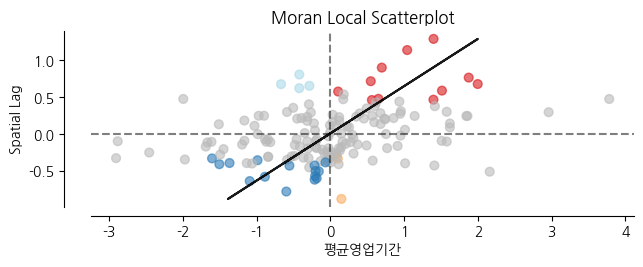

In [27]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

# calculate Moran_Local and plot
lisa = Moran_Local(y, w)
fig, ax = moran_scatterplot(lisa, p=0.05)
ax.set_xlabel('평균영업기간')
ax.set_ylabel('Spatial Lag')
plt.savefig(os.path.join(spatial_path,'Local_Moran\'I(평균영업기간).jpg'))
plt.show()

In [28]:
sig = lisa.p_sim < 0.05
sig.sum()

32

In [29]:
hotspots = lisa.q==1 * sig
hotspots.sum()

11

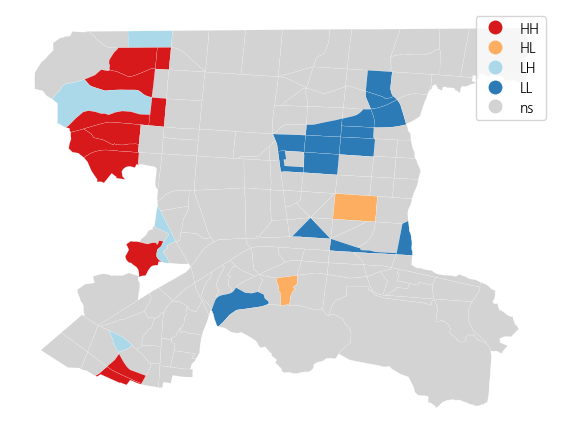

In [30]:
from splot.esda import lisa_cluster

gdf = gpd.GeoDataFrame(gdf)

lisa_cluster(lisa, gdf, p=0.05, figsize = (7,7))
plt.show()

# 3. OLS

In [31]:
import statsmodels.api as sm

X = ind_var
X = sm.add_constant(X)
y = clean_data.loc[:,'평균영업기간'].values
    
ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     3.596
Date:                Wed, 29 Dec 2021   Prob (F-statistic):           9.03e-07
Time:                        11:32:30   Log-Likelihood:                -728.98
No. Observations:                 158   AIC:                             1510.
Df Residuals:                     132   BIC:                             1590.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 174.5305     60.065      2.906      0.004      55.715     293.346
도로길이고려_전체통합도            0.0234      0.073      0.319      0.750      -0.122       0.168
도로길이고려_국부통합도_R3        -0.0012      0.006     -0.200      0.842      -0.013       0.011
기초구역평균_전체통합도         -175.0520    299.449     -0.585      0.560    -767.391     417.287
기초구역평균_국부통합도_R3       -75.0444     44.515     -1.686      0.094    -163.100      13.011
도로율                    -0.0407      0.259     -0.157      0.876      -0.554       0.473
평균 도로 길이               -0.0810      0.036     -2.265      0.025      -0.152      -0.010
평균최근접역거리               19.4777      6.071      3.208      0.002       7.468      31.487
평균최근접정류장거리           -124.2848     68.545     -1.813      0.072    -259.874      11.304
공동주택 비율                 0.4203      0.144      2.912      0.004       0.135       0.706
근린생활시설 비율               0.2863      0.132      2.168      0.032       0.025       0.547
단독주택 비율                 0.5883      0.163      3.614      0.000       0.266       0.910
아파트 가구수                -0.0036      0.003     -1.222      0.224      -0.009       0.002
외식업매출비율               -15.6246     25.007     -0.625      0.533     -65.091      33.841
서비스업매출비율                2.3509     24.841      0.095      0.925     -46.787      51.488
소매업매출비율               -16.8685     22.467     -0.751      0.454     -61.310      27.573
외식업종다양성               -10.6954      6.634     -1.612      0.109     -23.817       2.427
서비스업종다양성                8.5058      7.246      1.174      0.243      -5.828      22.839
소매업종다양성                 3.7824      7.972      0.474      0.636     -11.987      19.552
상가밀도                    0.0041      0.003      1.478      0.142      -0.001       0.010
주중 / 주말                16.7527     21.202      0.790      0.431     -25.187      58.693
06 to 18 / 18 to 06     3.6227     10.951      0.331      0.741     -18.039      25.284
(주거인구+직장인구) / 유동인구     12.2551     11.938      1.027      0.307     -11.360      35.871
주거인구/직장인구              -0.1354      0.111     -1.223      0.224      -0.354       0.084
10_30 / 40_60         -20.7444     40.424     -0.513      0.609    -100.707      59.218
점포밀도                   -0.0360      0.062     -0.584      0.560      -0.158       0.086
==============================================================================
Omnibus:                        8.385   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               13.839
Skew:                           0.214   Prob(JB):                     0.000988
Kurtosis:                       4.385   Cond. No.                     6.84e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance ma

# 4. 지리가중회귀분석(MGWR)

## 4.1 독립변수, 종속변수 설정

In [32]:
scaler = MinMaxScaler()
mm_scaled_dX = pd.DataFrame(scaler.fit_transform(ind_var.loc[:,optimal_feature]),columns=optimal_feature)

# 독립변수, 종속변수
s_X = mm_scaled_dX.values
s_y = clean_data['평균영업기간'].values.reshape((-1,1)) 

# 좌표 데이터 설정
u = clean_data['x'] # 경도
v = clean_data['y'] # 위도
s_coords = list(zip(u,v))

## 4.2 MODELING

In [34]:
#Calibrate MGWR model
# 평균영업기간

mgwr_selector = Sel_BW(s_coords, s_y, s_X,multi=True,kernel='f2',spherical=True)
mgwr_bw = mgwr_selector.search(criterion='AICc',multi_bw_min=[2])
print(mgwr_bw)
mgwr_model = MGWR(s_coords, s_y, s_X, mgwr_selector,kernel='f2',spherical=True,hat_matrix=True)
mgwr_results = mgwr_model.fit()

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[157.  64.  32.  75. 157. 157. 157. 157. 157. 157. 157. 157. 157. 157.
 157. 135.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [35]:
mgwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 158
Number of covariates:                                                    16

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         104826.347
Log-likelihood:                                                    -737.492
AIC:                                                               1506.984
AICc:                                                              1513.356
BIC:                                                             104107.459
R2:                                                                   0.337
Adj. R2:                                                              0.267

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

## 4.3 잔차 Moran's I 확인

### 4.3.1 MGWR

In [36]:
gdf = pd.DataFrame(clean_data.loc[:,'geometry'],columns=['geometry'])
# y = clean_data['평균영업기간'].values

y = mgwr_results.resid_response
w = Queen.from_dataframe(gdf)

moran = Moran(y, w,permutations=999)
moran.I

0.037515859239694915

In [37]:
print('{:.5f}'.format(moran.p_sim))
# 귀무가설을 기각할 수 없으므로 공간적으로 상관성이 없다고 말할 수 있다.

0.17500


### 4.3.2 OLS

In [38]:
import statsmodels.api as sm

X = mm_scaled_dX
X = sm.add_constant(X)
y = clean_data.loc[:,'평균영업기간'].values

ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     4.822
Date:                Wed, 29 Dec 2021   Prob (F-statistic):           1.68e-07
Time:                        11:34:32   Log-Likelihood:                -737.49
No. Observations:                 158   AIC:                             1507.
Df Residuals:                     142   BIC:                             1556.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                102.8975     15.406      6.679      0.000      72.443     133.352
주거인구/직장인구            -26.2978     29.191     -0.901      0.369     -84.003      31.408
아파트 가구수              -27.8773     14.910     -1.870      0.064     -57.352       1.597
단독주택 비율               59.7504     14.925      4.003      0.000      30.246      89.255
서비스업매출비율              12.3824     13.327      0.929      0.354     -13.962      38.727
외식업매출비율               -6.2146     10.481     -0.593      0.554     -26.933      14.503
근린생활시설 비율             25.7340     12.572      2.047      0.043       0.881      50.587
평균최근접역거리              39.3385      9.427      4.173      0.000      20.704      57.973
(주거인구+직장인구) / 유동인구    14.6521     14.418      1.016      0.311     -13.850      43.154
공동주택 비율               42.9862     13.321      3.227      0.002      16.654      69.318
평균 도로 길이             -33.4434     15.461     -2.163      0.032     -64.008      -2.879
도로길이고려_전체통합도           0.9037     12.405      0.073      0.942     -23.619      25.427
평균최근접정류장거리           -35.8325     18.540     -1.933      0.055     -72.482       0.817
점포밀도                 -22.4930     36.395     -0.618      0.538     -94.438      49.452
도로율                  -10.7827     15.060     -0.716      0.475     -40.553      18.988
상가밀도                  30.2310     33.842      0.893      0.373     -36.668      97.131
==============================================================================
Omnibus:                        4.615   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.100   Jarque-Bera (JB):                5.700
Skew:                           0.134   Prob(JB):                       0.0578
Kurtosis:                       3.891   Cond. No.                         31.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
gdf = pd.DataFrame(clean_data.loc[:,'geometry'],columns=['geometry'])
# y = clean_data['평균영업기간'].values

y = results.resid
w = Queen.from_dataframe(gdf)

moran = Moran(y, w,permutations=999)
moran.I

0.11371543710701495

In [40]:
moran.p_sim

0.009

## 4.4 MGWR 회귀계수

In [ ]:
mgwr_coef_df = pd.DataFrame(mgwr_results.params)
mgwr_coef_df.columns = ['intercept']+optimal_feature
mgwr_coef_df['x'] = u
mgwr_coef_df['y'] = v
mgwr_coef_df['BAS_ID'] = clean_data['BAS_ID']
mgwr_coef_df.to_csv('../data/전처리 파일/회귀계수/MGWR 회귀계수(평균영업기간,mm,data_1222).csv',index=False,encoding='euc-kr')

In [41]:
mgwr_coef_df = pd.DataFrame(mgwr_results.params,index=clean_data.BAS_ID)
mgwr_coef_df.columns = ['intercept']+optimal_feature

In [42]:
agg_coef = mgwr_coef_df.describe()

In [43]:
agg_coef_T = agg_coef.loc[['min','max','mean','std'],:].transpose()
agg_coef_T
agg_coef_T.to_csv('../data/전처리 파일/회귀계수/회귀계수 통계량(평균영업기간).csv',encoding='euc-kr')

### 4.2.1 Column별 회귀계수 분포

In [44]:
coef_ols = pd.DataFrame({'columns':['const']+optimal_feature
                            ,'coef':results.params})

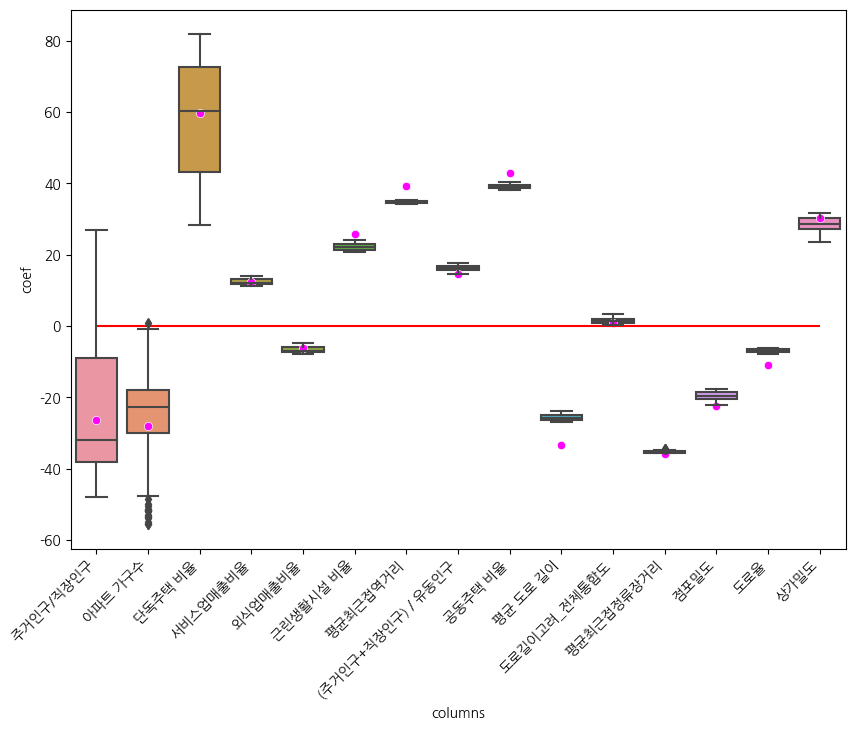

In [45]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,7))

sns.boxplot(data=mgwr_coef_df.iloc[:,1:],ax=ax)
sns.scatterplot(x='columns',y='coef',data=coef_ols.iloc[1:,:],color='magenta',ax=ax)
ax.set_xticklabels(mgwr_coef_df.columns[1:], rotation=45, ha='right')
ax.hlines(y=0,color='red',xmin=0,xmax=14)

plt.savefig('../data/결과 이미지/회귀계수 boxplot(평균영업기간).jpg')
plt.show()

 ## 4.5 local collinearity

In [46]:
local_con_num = pd.Series(mgwr_results.local_collinearity()[0].flatten())

In [47]:
local_con_num.sort_values(ascending=False)

22     26.966545
20     26.504973
19     26.235460
26     26.052574
21     25.938919
         ...    
92     22.934279
124    22.923920
87     22.920475
86     22.915000
85     22.823202
Length: 158, dtype: float64

## 4.6 Restriction Distance

In [48]:
def local_cdist(coords_i, coords, spherical):
    """
    Compute Haversine (spherical=True) or Euclidean (spherical=False) distance for a local kernel.
    """
    if spherical:
        dLat = np.radians(coords[:, 1] - coords_i[1])
        dLon = np.radians(coords[:, 0] - coords_i[0])
        lat1 = np.radians(coords[:, 1])
        lat2 = np.radians(coords_i[1])
        a = np.sin(
            dLat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dLon / 2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        R = 6371.0
        return R * c
    else:
        return np.sqrt(np.sum((coords_i - coords)**2, axis=1))

In [49]:
bw_list = range(10,158,10)
pos_count = 158
coords = np.array(s_coords)
eps = 1.0000001

df = pd.DataFrame({'BAS_ID':clean_data['BAS_ID']})

for bw in bw_list:
    max_dis_list = []
    for i in range(pos_count): 
        dis_list = local_cdist(coords[i],coords,True)
        max_dis = np.partition(dis_list,int(bw) - 1)[int(bw) - 1] * eps  #partial sort in O(n) Time
#         print(max_dis)
        max_dis_list.append(max_dis)
    
    df[str(bw)] = max_dis_list

df.head()

,BAS_ID,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150
0,21300,1.378723,2.074619,3.002842,3.243744,3.569759,3.847344,4.110799,4.313339,4.425246,4.665746,4.782738,4.962007,5.197556,5.423339,5.869606
1,21301,1.118967,2.071483,2.680156,3.100215,3.403442,3.619171,3.863232,4.202105,4.372615,4.539064,4.720418,4.970676,5.297170,5.526046,5.912755
2,21302,1.067706,1.751039,2.306041,2.651497,3.028297,3.297405,3.598324,3.773523,4.046633,4.227054,4.487645,4.741544,5.050247,5.471016,5.758121
3,21303,0.863112,1.630758,2.325094,2.702566,2.933544,3.226394,3.442623,3.742994,3.933228,4.103658,4.341009,4.505116,4.831268,5.147118,5.499029
4,21304,0.869947,1.452804,1.998713,2.395312,2.752247,2.979456,3.251223,3.451830,3.673363,3.956904,4.129783,4.379277,4.702059,5.130295,5.437791


In [50]:
df.describe()

,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,0.752988,1.158043,1.519311,1.803433,2.078864,2.328352,2.553885,2.768612,2.979218,3.205461,3.436918,3.683876,3.974349,4.375050,4.867013
std,0.223535,0.312790,0.439324,0.504812,0.580019,0.625910,0.652232,0.661257,0.668946,0.680058,0.693084,0.707630,0.710705,0.753774,0.817356
min,0.489206,0.789802,0.980086,1.192307,1.396221,1.569728,1.710993,1.893649,2.028311,2.216493,2.406066,2.647971,2.921610,3.179219,3.502366
25%,0.595536,0.925055,1.181257,1.414130,1.613546,1.843263,2.010990,2.252758,2.446159,2.664599,2.870070,3.085487,3.411041,3.772089,4.187726
50%,0.709126,1.073655,1.378748,1.625089,1.883058,2.094065,2.337831,2.560482,2.781213,3.034816,3.291411,3.532286,3.814687,4.265253,4.765295
75%,0.839194,1.313687,1.740225,2.132869,2.476525,2.773471,3.007662,3.247081,3.451693,3.676902,3.932821,4.207906,4.513580,4.958590,5.435988
max,1.831105,2.360533,3.002842,3.243744,3.595672,3.886201,4.134748,4.371194,4.576700,4.832184,5.135146,5.388506,5.669060,6.440329,7.243964


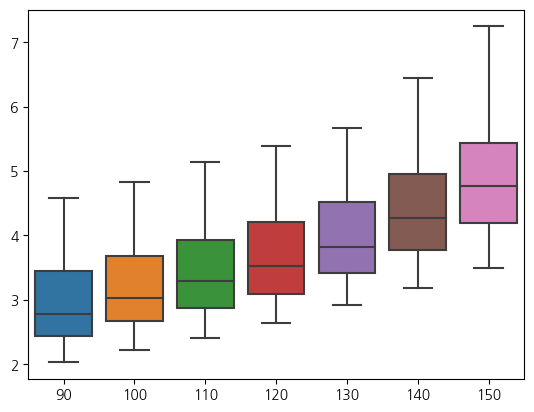

In [51]:
sns.boxplot(data=df.loc[:,'90':])
plt.savefig('../data/결과 이미지/restrict_bw(평균영업기간).jpg')
plt.show()

In [52]:
dist_Q3 = dict(df.describe().loc['75%'])
max_dist_dict = dist_Q3
max_dist_dict['158'] = 6.400214
max_dist_dict

{'10': 0.8391944829688937,
 '20': 1.3136872825562433,
 '30': 1.7402245179004976,
 '40': 2.132869322404663,
 '50': 2.476524657172923,
 '60': 2.7734710095769013,
 '70': 3.007661643840447,
 '80': 3.2470805931864253,
 '90': 3.451693201832052,
 '100': 3.6769022321023623,
 '110': 3.9328205206873204,
 '120': 4.207906364082775,
 '130': 4.51357970177413,
 '140': 4.958590008527771,
 '150': 5.435987711755927,
 '158': 6.400214}

In [53]:
temp_bw = []

for bw in range(10,159):
    start_bw = int(bw / 10)*10
    start_dist = max_dist_dict[str(int(start_bw))]
    
    if start_bw != 150:
        temp_bw.append(start_dist+(max_dist_dict[str(int(start_bw)+10)]-start_dist)/10*(bw-start_bw))
    else:
        temp_bw.append(start_dist+(max_dist_dict[str(int(start_bw)+8)]-start_dist)/8*(bw-start_bw))
    
distance_by_bw = pd.DataFrame({'bw':range(10,159),'distance':temp_bw})

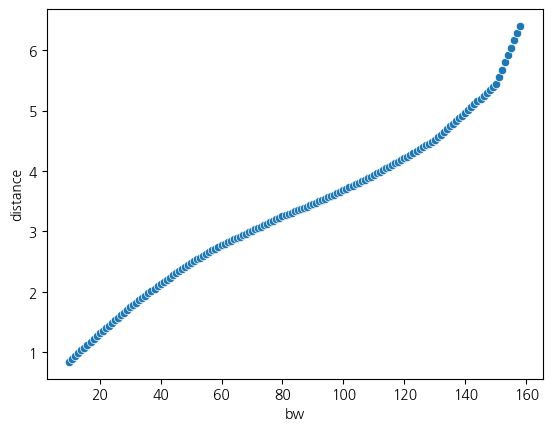

In [54]:
sns.scatterplot(x=distance_by_bw['bw'],y=distance_by_bw['distance'])
plt.savefig('../data/결과 이미지/restrict_bw_smooth_graph(평균영업기간).jpg')
plt.show()